In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
scaler = MinMaxScaler()

In [3]:
df = pd.read_excel("DJIA Realized Volatility.xlsx",index_col='Date',parse_dates=True)
df_for_date=df[int(len(df['Realised'])*0.7):].reset_index()

In [4]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  for i in range(len(test)):
    row = [[a] for a in scaled_test_input[i:i+window_size]]
    X.append(row)
  return np.array(X)

Epoch: 7 | Inputs: 126 | Nodes: 126 | Dropout: 0 | Loss: mse

# H=1 Forecasts

In [5]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [6]:
for i in range (15):
  n_features = 2
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(len(test), n_input, n_features)
  y_hat=model.predict(X)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
60/60 [==============================] - 8s 11ms/step - loss: 0.0043 - accuracy: 5.2083e-04 - mean_absolute_error: 0.0407
Epoch 2/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 5.2083e-04 - mean_absolute_error: 0.0351
Epoch 3/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0031 - accuracy: 5.2083e-04 - mean_absolute_error: 0.0335
Epoch 4/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0030 - accuracy: 5.2083e-04 - mean_absolute_error: 0.0329
Epoch 5/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0029 - accuracy: 5.2083e-04 - mean_absolute_error: 0.0315
Epoch 6/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0028 - accuracy: 5.2083e-04 - mean_absolute_error: 0.0314
Epoch 7/7
55/55 [==============================] - 1s 3ms/step
Epoch 1/7
60/60 [==============================] - 4s 11ms/step - loss: 0.0103 - accuracy: 5.2083e-04 - mean_absolute_error: 0.0499
Epoch 2/7
60/60 [=

In [7]:
Accuracy

[65.3045086171102,
 50.29601147773135,
 64.49022145393099,
 57.45472275622958,
 66.286758020297,
 60.71958225236285,
 57.85114744866511,
 67.4383483270467,
 58.48371664377731,
 52.132227696351976,
 56.44899007668042,
 68.72487174180525,
 64.94437354192763,
 59.400441563782294,
 59.88053635801529]

In [8]:
RMSE

[0.0025113863638433196,
 0.00304895329270125,
 0.0025463309626268973,
 0.0026533950739640335,
 0.0025030527109417503,
 0.0025759476861687983,
 0.0026382784236754094,
 0.002483399065818907,
 0.002623063010991824,
 0.0027942613547583682,
 0.002762420885215936,
 0.002496077378565224,
 0.0025610494371617575,
 0.002659941913804607,
 0.002581996628423821]

In [9]:
Quasilikelihood

[0.08844886975807226,
 0.14185338665703812,
 0.08957946577482767,
 0.11355073532840285,
 0.08468584769185454,
 0.1011594775658357,
 0.11148901069774074,
 0.08168049702847431,
 0.10868489939351574,
 0.133633356317689,
 0.11543304622485161,
 0.07995908806529436,
 0.08938003647445701,
 0.10521168398654679,
 0.10398559749935643]

In [10]:
df_for_date=df[int(len(df['Realised'])*0.7):].reset_index()

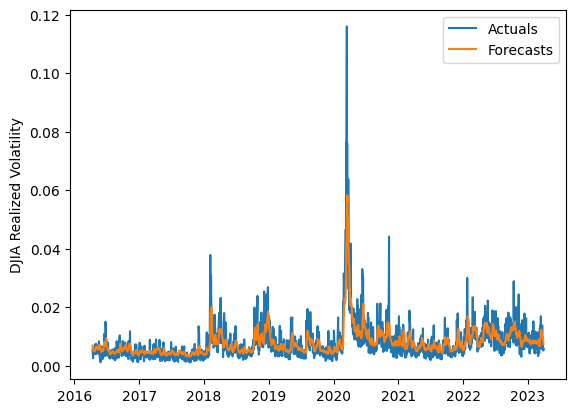

In [11]:
# Best model
plt.plot(df_for_date["Date"], test)
plt.plot(df_for_date["Date"], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=3 Forecasts

In [12]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [13]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/3)):
    row = [[a] for a in scaled_test_input[i*3:(i*3)+window_size]]
    X.append(row)
  return np.array(X)

In [14]:
for i in range (15):
  n_features = 2
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(3))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/3))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
60/60 [==============================] - 3s 10ms/step - loss: 0.0057 - accuracy: 0.4068 - mean_absolute_error: 0.0400
Epoch 2/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 0.3745 - mean_absolute_error: 0.0347
Epoch 3/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0033 - accuracy: 0.3484 - mean_absolute_error: 0.0348
Epoch 4/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 0.2375 - mean_absolute_error: 0.0354
Epoch 5/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0032 - accuracy: 0.3146 - mean_absolute_error: 0.0338
Epoch 6/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0030 - accuracy: 0.2682 - mean_absolute_error: 0.0323
Epoch 7/7
19/19 [==============================] - 0s 4ms/step
Epoch 1/7
60/60 [==============================] - 3s 11ms/step - loss: 0.0040 - accuracy: 0.2339 - mean_absolute_error: 0.0384
Epoch 2/7
60/60 [=============================

In [15]:
RMSE

[0.0031293493357524116,
 0.0026995863277132536,
 0.0026275412901334808,
 0.002636940208494018,
 0.0026386329837133366,
 0.0027521793004828647,
 0.0027268947150338274,
 0.0027582688703000776,
 0.002833829281219983,
 0.00273895158969963,
 0.0026608838310112604,
 0.0028658326695344288,
 0.00279798388162996,
 0.0030379319822536055,
 0.0027112117871639805]

In [16]:
Accuracy

[48.4555947616378,
 63.06962794399348,
 64.18495855067694,
 62.49014948628189,
 63.19559416276059,
 67.20066536167688,
 64.95496493475213,
 67.12918769600766,
 56.14685231534619,
 57.41311825328835,
 64.22491971335408,
 52.712761074734836,
 54.67078321024352,
 65.57472594586125,
 66.80302464145461]

In [17]:
Quasilikelihood

[0.150806413752104,
 0.10083825408481024,
 0.09584626856056293,
 0.10015910250134125,
 0.098620029053268,
 0.09996770968828302,
 0.10015142181020444,
 0.09859581385963062,
 0.12189025920564904,
 0.11636757229937983,
 0.09632140453881813,
 0.13526385671498542,
 0.12782101196583787,
 0.12336290318639723,
 0.09570743130984281]

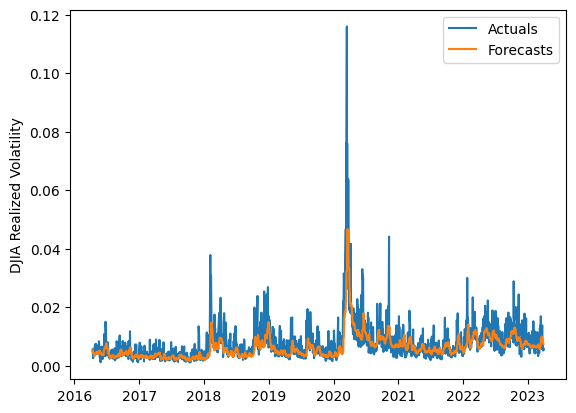

In [18]:
# Best model
plt.plot(df_for_date["Date"], test)
plt.plot(df_for_date["Date"], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=5 Forecasts

In [19]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [20]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/5)):
    row = [[a] for a in scaled_test_input[i*5:(i*5)+window_size]]
    X.append(row)
  return np.array(X)

In [21]:
for i in range (15):
  n_features = 2
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(5))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/5))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
60/60 [==============================] - 3s 11ms/step - loss: 0.0042 - accuracy: 0.0167 - mean_absolute_error: 0.0403
Epoch 2/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 0.1312 - mean_absolute_error: 0.0347
Epoch 3/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0037 - accuracy: 0.0812 - mean_absolute_error: 0.0361
Epoch 4/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0031 - accuracy: 0.1312 - mean_absolute_error: 0.0333
Epoch 5/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0030 - accuracy: 0.1187 - mean_absolute_error: 0.0321
Epoch 6/7
60/60 [==============================] - 1s 11ms/step - loss: 0.0029 - accuracy: 0.2438 - mean_absolute_error: 0.0322
Epoch 7/7
11/11 [==============================] - 1s 4ms/step
Epoch 1/7
60/60 [==============================] - 3s 11ms/step - loss: 0.0046 - accuracy: 0.1688 - mean_absolute_error: 0.0408
Epoch 2/7
60/60 [============================

In [22]:
RMSE

[0.002809694384198792,
 0.002779980783364326,
 0.002872476629162093,
 0.0029826240063574364,
 0.002998652490056597,
 0.0027641842024577873,
 0.0028516249236754916,
 0.0028512000731001842,
 0.002790153146054097,
 0.002731237115729365,
 0.0028842240042805467,
 0.0027491100990020578,
 0.002856903574236894,
 0.0027245471935422945,
 0.002746344503779221]

In [23]:
Accuracy

[59.31334716828687,
 61.47994547410607,
 60.17491842967877,
 66.00365103070304,
 53.126561693837985,
 65.6347160407894,
 59.81110826753123,
 56.69961887964568,
 59.92503516327612,
 61.58002126197246,
 56.37393650864768,
 60.80154524542822,
 54.573042440396314,
 62.38180792831246,
 62.415975013572286]

In [24]:
Quasilikelihood

[0.11432100711328076,
 0.10751536225546265,
 0.11475701333400197,
 0.11463414363187607,
 0.1350527748023805,
 0.10104385530591206,
 0.11549629478319516,
 0.12189940188784272,
 0.11129551289644772,
 0.10655626809566314,
 0.12391220625705142,
 0.10886596091984548,
 0.1313170217698541,
 0.10415657050015209,
 0.10498466765164594]

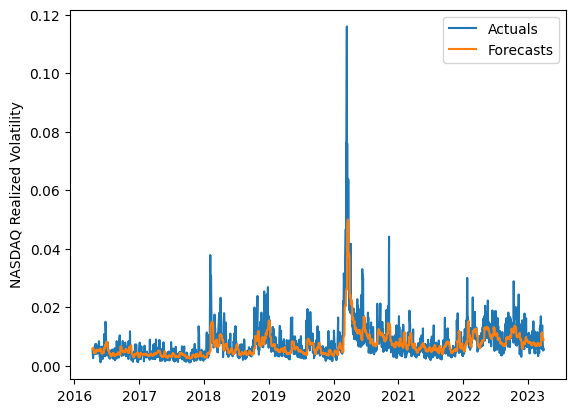

In [25]:
# Best model
plt.plot(df_for_date["Date"], test)
plt.plot(df_for_date["Date"], true_predictions) 
plt.ylabel("NASDAQ Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=10 Forecasts

In [26]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [27]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/10)):
    row = [[a] for a in scaled_test_input[i*10:(i*10)+window_size]]
    X.append(row)
  return np.array(X)

In [28]:
for i in range (15):
  n_features = 2
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(10))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  test=test[:len(test)-5]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/10))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
60/60 [==============================] - 3s 11ms/step - loss: 0.0049 - accuracy: 0.1964 - mean_absolute_error: 0.0384
Epoch 2/7
60/60 [==============================] - 1s 10ms/step - loss: 0.0035 - accuracy: 0.0635 - mean_absolute_error: 0.0347
Epoch 3/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0035 - accuracy: 0.1490 - mean_absolute_error: 0.0358
Epoch 4/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0032 - accuracy: 0.3000 - mean_absolute_error: 0.0336
Epoch 5/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0032 - accuracy: 0.2896 - mean_absolute_error: 0.0334
Epoch 6/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0032 - accuracy: 0.2214 - mean_absolute_error: 0.0340
Epoch 7/7
6/6 [==============================] - 0s 4ms/step
Epoch 1/7
60/60 [==============================] - 3s 11ms/step - loss: 0.0048 - accuracy: 0.0063 - mean_absolute_error: 0.0408
Epoch 2/7
60/60 [==============================

In [29]:
RMSE

[0.0029562344548735757,
 0.003390103560026484,
 0.0029750504867838887,
 0.0029169913829548847,
 0.0030763748213660865,
 0.002909836800823472,
 0.003012054391690794,
 0.003004586256432762,
 0.003130393475191189,
 0.0029528137270686773,
 0.0031359985839917682,
 0.0036761273818225575,
 0.0029869547525584027,
 0.0029951476926126795,
 0.002922179731807263]

In [30]:
Accuracy

[58.9594188258167,
 39.559787346930044,
 54.663865017207215,
 61.290184947800796,
 61.41432612267689,
 60.495532245390585,
 55.9401924404615,
 62.26093310525664,
 49.89838781428251,
 63.137306780940236,
 50.737050319109386,
 37.18220339020688,
 63.450295328482895,
 54.361687813865146,
 60.53508690752302]

In [31]:
Quasilikelihood

[0.12282595891485601,
 0.19873084107160496,
 0.13671975352045415,
 0.11797461057829721,
 0.1319633052103956,
 0.11841007198882851,
 0.1331002779989034,
 0.12061879172379986,
 0.1541089412845746,
 0.11577963613328214,
 0.15059008520762482,
 0.20696443528373148,
 0.11893283213798404,
 0.13816603745721429,
 0.1188229353699852]

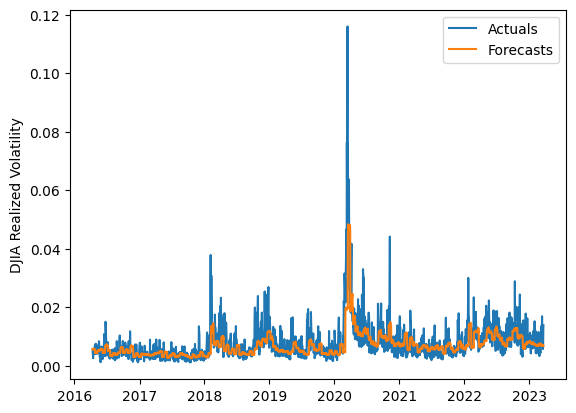

In [32]:
# Best model
plt.plot(df_for_date["Date"][:1750], test)
plt.plot(df_for_date["Date"][:1750], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])

# H=22 Forecasts

In [33]:
RMSE = []
Accuracy = []
Quasilikelihood=[]

In [34]:
def df_to_X_y(window_size,test,scaled_test_input):
  X=[]
  y=[]
  for i in range(int(len(test)/22)):
    row = [[a] for a in scaled_test_input[i*22:(i*22)+window_size]]
    X.append(row)
  return np.array(X)

In [35]:
for i in range (15):
  n_features = 2
  n_input = 126
  train = df.iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df.iloc[int(len(df['Realised'])*0.7)-n_input:]
  scaler.fit(train)
  scaled_train_input = scaler.transform(train)
  scaled_test_input = scaler.transform(test)
  train = df["Realised"].iloc[:int(len(df['Realised'])*0.7)]
  train = train[int(len(train)*0.5):]
  test = df["Realised"].iloc[int(len(df['Realised'])*0.7):]
  train = train.array.reshape(-1, 1)
  test = test.array.reshape(-1, 1)
  scaler.fit(train)
  scaled_train_target = scaler.transform(train)
  scaled_test_target = scaler.transform(test)
  generator = TimeseriesGenerator(scaled_train_input, scaled_train_target, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(126, activation='tanh', input_shape=(n_input, n_features)))
  model.add(Dense(22))
  model.compile(optimizer='adam', loss='mse', metrics=["accuracy", "mean_absolute_error"])
  model.fit(generator,epochs=7)
  test=test[:len(test)-17]
  X = df_to_X_y(n_input,test,scaled_test_input)
  X=X.reshape(int(((len(test)/22))), n_input, n_features)
  y_hat=model.predict(X)
  y_hat=y_hat.reshape(len(test),1)
  true_predictions = scaler.inverse_transform(y_hat)
  RMSE.append(np.sum(np.sqrt((test-true_predictions)**2))/len(test))
  Accuracy.append((1-np.sum(np.sqrt((test-true_predictions)**2)/test)/(len(test)))*100)
  Quasilikelihood.append(np.sum(true_predictions/test-np.log(true_predictions/test)-1)/len(test))

Epoch 1/7
60/60 [==============================] - 3s 12ms/step - loss: 0.0053 - accuracy: 0.0333 - mean_absolute_error: 0.0447
Epoch 2/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0040 - accuracy: 0.0964 - mean_absolute_error: 0.0358
Epoch 3/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0039 - accuracy: 0.0036 - mean_absolute_error: 0.0365
Epoch 4/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0034 - accuracy: 0.0250 - mean_absolute_error: 0.0347
Epoch 5/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0033 - accuracy: 0.0229 - mean_absolute_error: 0.0337
Epoch 6/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0031 - accuracy: 0.0135 - mean_absolute_error: 0.0332
Epoch 7/7
3/3 [==============================] - 0s 9ms/step
Epoch 1/7
60/60 [==============================] - 3s 11ms/step - loss: 0.0050 - accuracy: 0.1146 - mean_absolute_error: 0.0432
Epoch 2/7
60/60 [==============================]

3/3 [==============================] - 0s 6ms/step
Epoch 1/7
60/60 [==============================] - 3s 13ms/step - loss: 0.0048 - accuracy: 0.0031 - mean_absolute_error: 0.0416
Epoch 2/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0036 - accuracy: 0.0130 - mean_absolute_error: 0.0351
Epoch 3/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0050 - accuracy: 0.0125 - mean_absolute_error: 0.0408
Epoch 4/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 0.1099 - mean_absolute_error: 0.0349
Epoch 5/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0032 - accuracy: 0.0276 - mean_absolute_error: 0.0333
Epoch 6/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0032 - accuracy: 0.0359 - mean_absolute_error: 0.0335
Epoch 7/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0032 - accuracy: 0.0010 - mean_absolute_error: 0.0343


3/3 [==============================] - 0s 7ms/step
Epoch 1/7
60/60 [==============================] - 3s 10ms/step - loss: 0.0046 - accuracy: 0.0484 - mean_absolute_error: 0.0403
Epoch 2/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0038 - accuracy: 0.0141 - mean_absolute_error: 0.0359
Epoch 3/7
60/60 [==============================] - 1s 9ms/step - loss: 0.0036 - accuracy: 0.0500 - mean_absolute_error: 0.0355
Epoch 4/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0032 - accuracy: 0.1036 - mean_absolute_error: 0.0335
Epoch 5/7
60/60 [==============================] - 0s 8ms/step - loss: 0.0032 - accuracy: 0.0568 - mean_absolute_error: 0.0338
Epoch 6/7
60/60 [==============================] - 1s 8ms/step - loss: 0.0032 - accuracy: 0.0276 - mean_absolute_error: 0.0335
Epoch 7/7
3/3 [==============================] - 1s 6ms/step
Epoch 1/7
60/60 [==============================] - 3s 11ms/step - loss: 0.0052 - accuracy: 0.0000e+00 - mean_absolute_error: 

In [36]:
RMSE

[0.003226040168194333,
 0.0033317710624826496,
 0.003539618982320911,
 0.003354631803435772,
 0.003262988408139391,
 0.003344559534522512,
 0.0033324276646357906,
 0.0033325555656617497,
 0.003210035677712677,
 0.003613563189087096,
 0.003263000262717218,
 0.0036893984662559266,
 0.0032685897907280843,
 0.0032647943081006384,
 0.0033181892768227566]

In [37]:
Accuracy

[60.901591693961834,
 51.7567788226266,
 49.50126675404518,
 58.73253084044777,
 61.00294665944469,
 58.12812092943194,
 51.96871732668242,
 53.00484178517833,
 57.55490739923913,
 43.11139546460572,
 56.92091984147394,
 42.47970169372513,
 56.370239614283555,
 56.59677932181842,
 50.45223506320162]

In [38]:
Quasilikelihood

[0.13175474164703596,
 0.15332036868887172,
 0.16398469168400187,
 0.13788625002792965,
 0.13612474705435976,
 0.14069210768781357,
 0.15208518628402187,
 0.14977832144826228,
 0.13636810847156233,
 0.1862643355131847,
 0.13833907404402093,
 0.19028301968612965,
 0.138978572476362,
 0.13865921038169574,
 0.15792608783605772]

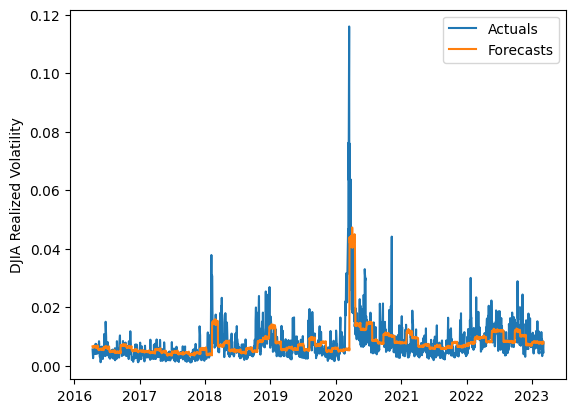

In [39]:
# Best model
plt.plot(df_for_date["Date"][:1738], test)
plt.plot(df_for_date["Date"][:1738], true_predictions) 
plt.ylabel("DJIA Realized Volatility")
plt.legend(['Actuals', 'Forecasts'])